In [336]:
import keras
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from keras.datasets import mnist
from pandas import DataFrame, read_csv
import random
import os
import math
from keras.callbacks import Callback

# USE_GPU = True
# if USE_GPU:
#     print(tf.config.list_physical_devices('GPU'))


# About the Data

Attribute Information:

Input variables:

## bank client data:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

## related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

## social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

## Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Import All Data and Move to Correct Destination

In [337]:
bank_client_data = [
  "age",
  "job",
  "marital",
  "education",
  "default",
  "housing",
  "loan",
  "contact",
  "month",
  "day_of_week",
  "duration"
]

other_attributes = [
  "campaign",
  "pdays",
  "previous",
  "poutcome"
]

social_and_economic_context_attributes = [
  "emp.var.rate",
  "cons.price.idx",
  "cons.conf.idx",
  "euribor3m",
  "nr.employed"
]

potentially_useless_columns = [
    "pdays",
    "default"
]


In [338]:
# the percentage of random samples used to dedicate to validating the model.
# All other rows will be used for training.
VALIDATION_DATA_PERCENTAGE = 0.1
GENERATE_RANDOM_INDICES = False

full_dataset_df = read_csv("translated-normalized-df.csv")

# see if social_and_economic_context_attributes contains useless information
# full_dataset_df.drop(columns=potentially_useless_columns, inplace=True)

# generate random indices for validation or read existing indices from memory
def get_random_indices():

  if GENERATE_RANDOM_INDICES:
    num_rows = full_dataset_df.shape[0]
    num_indices  = int(num_rows * VALIDATION_DATA_PERCENTAGE)
    return random.sample(range(num_rows), num_indices)
  
  else:
    random_indices_df = read_csv("random_indices_df.csv")
    return list(random_indices_df['random_indices'])

random_indices = get_random_indices()

# create separate DataFrames for training and validation
validation_df = full_dataset_df.iloc[random_indices]
training_df = full_dataset_df.drop(random_indices)

target_df = training_df.pop('target')
validation_target_df = pd.DataFrame(validation_df.pop('target')) # drop this column, but also return a dataframe

if GENERATE_RANDOM_INDICES:
  # save the indices just in case we want to use this seed again
  random_indices_df = DataFrame()
  random_indices_df['random_indices'] = random_indices
  random_indices_df.to_csv("random_indices_df.csv")

# Overview of the Training and Validation Data

In [339]:
validation_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
13269,-0.865939,-0.274518,-0.732858,-0.126988,-0.513684,0.790990,-0.438089,0.75857,0.192116,0.014466,1.279389,-0.565922,0.195414,-0.349494,-0.372802,0.839061,0.591424,-0.474791,0.772999,0.845170
3563,1.628993,0.947933,2.137526,1.245696,-0.513684,-1.056746,-0.438089,-1.31827,-0.787808,1.431401,-0.568062,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.713613,0.331680
15860,0.189609,-1.496969,2.137526,-1.499673,-0.513684,0.790990,-0.438089,0.75857,0.192116,-1.402469,-0.722338,2.322186,0.195414,-0.349494,-0.372802,0.839061,0.591424,-0.474791,0.771846,0.845170
32043,-0.865939,-0.274518,-0.732858,-0.126988,-0.513684,-1.056746,-0.438089,0.75857,-0.787808,0.722934,-0.178516,-0.565922,0.195414,-0.349494,-0.372802,-1.197935,-1.179380,-1.231034,-1.322795,-0.940281
13274,-0.002309,1.355416,-0.732858,1.245696,1.946935,0.790990,-0.438089,0.75857,0.192116,0.014466,-0.560349,-0.565922,0.195414,-0.349494,-0.372802,0.839061,0.591424,-0.474791,0.772999,0.845170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29770,0.957281,2.577867,-0.732858,-1.042111,-0.513684,0.790990,-0.438089,0.75857,-1.277771,-1.402469,-0.004956,-0.565922,0.195414,-0.349494,-0.372802,-1.197935,-0.864955,-1.425496,-1.277824,-0.940281
6740,-0.578062,-0.274518,-0.732858,-1.499673,-0.513684,-1.056746,-0.438089,-1.31827,-0.787808,0.014466,-0.251797,-0.204909,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
12659,-0.098268,-1.089485,-0.732858,-0.126988,-0.513684,-1.056746,1.754912,0.75857,0.192116,-1.402469,-0.799476,-0.204909,0.195414,-0.349494,-0.372802,0.839061,0.591424,-0.474791,0.771846,0.845170
5848,-0.386145,-0.682002,-0.732858,1.245696,-0.513684,0.790990,-0.438089,-1.31827,-0.787808,-1.402469,-0.463926,-0.204909,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680


In [340]:
training_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,-1.496969,-0.732858,-1.499673,-0.513684,-1.056746,-0.438089,-1.31827,-0.787808,-1.402469,0.010471,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
1,1.628993,-1.089485,-0.732858,-1.042111,1.946935,-1.056746,-0.438089,-1.31827,-0.787808,-1.402469,-0.421501,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
2,-0.290186,-1.089485,-0.732858,-1.042111,-0.513684,0.790990,-0.438089,-1.31827,-0.787808,-1.402469,-0.124520,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
4,1.533034,-1.089485,-0.732858,-1.042111,-0.513684,-1.056746,1.754912,-1.31827,-0.787808,-1.402469,0.187888,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
5,0.477486,-1.089485,-0.732858,-0.126988,1.946935,-1.056746,-0.438089,-1.31827,-0.787808,-1.402469,-0.232513,-0.565922,0.195414,-0.349494,-0.372802,0.648092,0.722722,0.886447,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41182,-1.057857,1.355416,0.702334,-1.499673,-0.513684,0.790990,-0.438089,0.75857,2.151966,1.431401,-0.564206,-0.565922,-5.101292,1.671136,4.015586,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41183,3.164336,0.540449,-0.732858,0.330573,-0.513684,0.790990,-0.438089,0.75857,2.151966,1.431401,0.292025,-0.565922,0.195414,-0.349494,-0.372802,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41184,0.573445,-0.274518,-0.732858,0.330573,-0.513684,-1.056746,-0.438089,0.75857,2.151966,1.431401,0.481012,-0.565922,0.195414,-0.349494,-0.372802,-0.752343,2.058168,-2.224953,-1.495186,-2.815697
41185,1.533034,0.540449,-0.732858,1.245696,-0.513684,0.790990,-0.438089,0.75857,2.151966,1.431401,-0.267225,-0.204909,0.195414,-0.349494,-0.372802,-0.752343,2.058168,-2.224953,-1.495186,-2.815697


# Construct the Network's Architecture

In [341]:
'''
tensorflow activation types
https://www.researchgate.net/figure/Sigmoid-Scaled-Exponential-Linear-Unit-SELU-Hyperbolic-tangent-TanH-Rectifier_fig1_350125835

"softmax": Used for multiclass classification problems. It outputs a probability distribution over the classes.
"sigmoid": Used for binary classification problems. It outputs a value between 0 and 1 that can be interpreted as a probability of belonging to the positive class.
"tanh": Hyperbolic tangent activation function. It outputs a value between -1 and 1 and is commonly used in hidden layers.
"relu": Rectified Linear Unit activation function. It outputs a value greater than or equal to zero and is also commonly used in hidden layers.
"LeakyReLU"
"PReLU": LeakyReLU but more negative gain
"elu": Exponential Linear Unit activation function. It is similar to the relu function, but with a smooth transition for negative values.
"selu": Scaled Exponential Linear Unit activation function. It is similar to the elu function, but with a different scaling factor for the negative values.
"linear": The default activation function. It just passes the output of the layer as is without any nonlinearity.
'''

# assemble the fully connected network
number_of_columns = training_df.shape[1]

model = Sequential([
    keras.layers.Dense(64, activation='PReLU', input_shape=(number_of_columns,)),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(32, activation='LeakyReLU'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(16, activation='relu'),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 64)                1408      
                                                                 
 batch_normalization_46 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_118 (Dense)           (None, 32)                2080      
                                                                 
 batch_normalization_47 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_119 (Dense)           (None, 16)                528       
                                                                 
 batch_normalization_48 (Bat  (None, 16)             

# Skew the Assymetric Binary Classifer Data

In [342]:
# determine the ratio between ones and zeros for the target training 
n_nills, n_ones = target_df.value_counts()
desired_percentage = 0.5 # ideally, a binary classifier should have a 50/50 sample. So, let's skew the magnitude of the training data.

total = n_nills + n_ones
nill_percentage = n_nills / total
ones_percentage = n_ones / total

# nill_skew = desired_percentage / nill_percentage
# ones_skew = desired_percentage / ones_percentage

nill_skew = 1.0
ones_skew = 1.1
print("nill_skew:", nill_skew)
print("ones_skew:", ones_skew)

nill_skew: 1.0
ones_skew: 1.1


# Train the Network

In [343]:
'''
class_weight parameter:
Optional dictionary mapping class indices (integers) to a weight (float)
value, used for weighting the loss function (during training only).
This can be useful to tell the model to "pay more attention" to samples
from an under-represented class. https://www.tensorflow.org/api_docs/python/tf/keras/Model
'''

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print("Starting Training.")

history = model.fit(
    training_df,
    target_df,
    validation_data=(validation_df, validation_target_df),
    # batch_size=5,
    class_weight={0: nill_skew, 1: ones_skew}, # skew the training attenuate the prominence of a "null" row, and make a "one" row more prominent
    epochs=10
)

print("Training is complete.")

Starting Training.
Epoch 1/10
1159/1159 [==============================] - 8s 5ms/step - loss: 0.2911 - accuracy: 0.8854 - val_loss: 0.2087 - val_accuracy: 0.9043
Epoch 2/10
1159/1159 [==============================] - 7s 6ms/step - loss: 0.2166 - accuracy: 0.9069 - val_loss: 0.1969 - val_accuracy: 0.9041
Epoch 3/10
1159/1159 [==============================] - 5s 4ms/step - loss: 0.2084 - accuracy: 0.9066 - val_loss: 0.1984 - val_accuracy: 0.9036
Epoch 4/10
1159/1159 [==============================] - 6s 5ms/step - loss: 0.2043 - accuracy: 0.9088 - val_loss: 0.1913 - val_accuracy: 0.9063
Epoch 5/10
1159/1159 [==============================] - 6s 6ms/step - loss: 0.2003 - accuracy: 0.9105 - val_loss: 0.1882 - val_accuracy: 0.9114
Epoch 6/10
1159/1159 [==============================] - 5s 4ms/step - loss: 0.1977 - accuracy: 0.9115 - val_loss: 0.1874 - val_accuracy: 0.9119
Epoch 7/10
1159/1159 [==============================] - 6s 5ms/step - loss: 0.1958 - accuracy: 0.9111 - val_loss: 0.1

# Validate the Network

In [344]:
print("Starting Testing.")
scores = model.evaluate(validation_df, validation_target_df)
print("Testing is Complete.")
print("test loss, test accuracy:", scores)

# configure for validation section
result = list(model.predict(validation_df))
validation_target_df['result'] = result

Starting Testing.
129/129 [==============================] - 0s 2ms/step - loss: 0.1849 - accuracy: 0.9148
Testing is Complete.
test loss, test accuracy: [0.18489906191825867, 0.9147644639015198]
129/129 [==============================] - 0s 2ms/step


# Determine the accuracy of the binary classifier with true/false positive/negative

In [345]:
TP: int = 0
TN: int = 0
FP: int = 0
FN: int = 0

for idx, row in validation_target_df.iterrows():

    result = float(row['result'])
    target = row['target']

    # predicted: positive
    if result > 0.5:
        
        # true positive 
        if target == 1: TP += 1
        
        # false positive
        else: FP += 1
    
    # predicted: negative
    else:

        # true negative
        if target == 0: TN += 1

        # false negative
        else: FN += 1

Text(0.5, 1.0, 'Loss Curves')

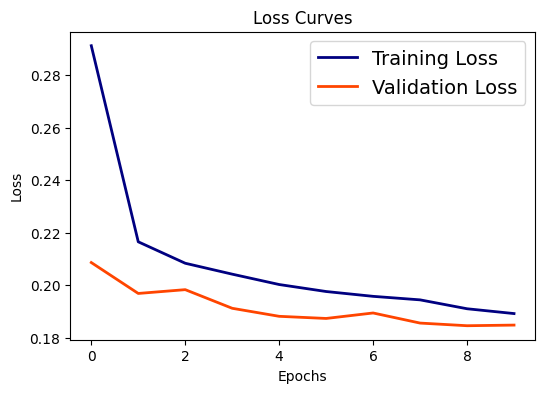

In [346]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'navy', linewidth=2.0)
plt.plot(history.history['val_loss'], 'orangered', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

Text(0.5, 1.0, 'Accuracy Curves')

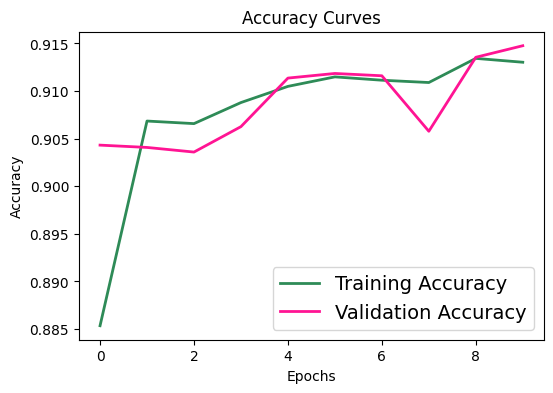

In [347]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'seagreen', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'deeppink', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

# Print the Final Results of the Network

In [348]:
print(
f'''true positives: {TP}
true negatives: {TN}
false positives: {FP}
false negatives: {FN}''')

# determine the accuracy, precision, and recall
accuracy = (TP + TN) / (TN + FN + TP + FP)
precision = TP / (TP + FP)
recall = TP / (TP +FN)

print(f'''
accuracy: {accuracy * 100}
precision: {precision * 100}
recall: {recall * 100}''')

true positives: 253
true negatives: 3514
false positives: 135
false negatives: 216

accuracy: 91.47644487615348
precision: 65.20618556701031
recall: 53.94456289978679
